# Loans EDA

## Fields description

`profile_id` is the unique identificator of a customer. One customer could have many loans.

`app_id` is the unique identificator of an application. One customer could have many applications and not every application results in a loan.

`loan` is the unique identificator of a loan.

`begin_date` is the date when a loan was granted to a client.

`end_date` is the planned date of repayment according to loan's schedule. If a loan was prolongued this date will account for the last planned date of repayment.

`amount` is the amount granted to the a client when a loan was originated.

`product` is the internal classification of financial structure of a loan as a product. **START** corresponds to the product with initial commission and then some grace period for interest. **START_11** as oposite has no initial commission by incorporates intrest rate form the vary begining. Total loan overpayment is the same for both products.

`status` is the status of a loan. Possible values are: **OVERDUE**, **REPAID**, **CLOSED**. There is only technical difference between **REPAID** and **CLOSED**. Thus status **REPAID** can be treated as **CLOSED** for the purpose of this analysis.

`lodging_cnt` accounts for the number of prolongations of a loan.

`repayment_ratio` is the total amount repayed by a customer divided by begin amount granted to that customer in boundaries of a single loan.

## Additional notes from the owners of the dataset

1. Loans granted before 2018-06-01 where technicaly test loans and should be omited for the purpose of this analysis.

2. For the loans granted from 2018-06-01 till February 2019 loan amount was limited at 2 UAHk. Somewhere at the end of February 2019 the cap was raised to 3 UAHk for new clients ans 4 UAHk for existing clients.

3. During autumn 2018 they conducted kind of test granting some bad customers 100 UAH loans instead of rejecting their applications.

4. During February-March 2019 they conducted kind of another test granting some bad customers 500 UAH loans instead of rejecting their applications.

5. Marketing activity was different during different months. This data can't be shared within this project.

6. It's suggested to treat loan as **GOOD** if it was repayed 90% of the begin amount or more and to treat loan as **GOOD** if it was repayed 10% of the begin amount or less. It's hard to classify loans if the repayment ratio is between 10% and 90%. Loans can be classified only 90 days after the date of origination.

## Load data

In [1]:
# load libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data

df_loans = pd.read_csv('loans.csv')
df_loans.head()

,profile_id,app_id,loan,begin_date,end_date,amount,product,status,lodging_cnt,repayment_ratio
0,158618,848153,34275,2020-01-16,2020-02-25,3500.0,START_11,CLOSED,1,1.486
1,709513,509688,21025,2019-06-14,2019-06-28,700.0,START_11,CLOSED,0,1.000
2,690248,518539,21232,2019-06-19,2019-06-30,2000.0,START_11,CLOSED,0,1.054
3,753344,755195,30938,2019-11-23,2019-12-07,700.0,START_11,CLOSED,0,1.036
4,416384,393817,17844,2019-04-09,2019-05-04,2300.0,START_11,CLOSED,1,1.180


In [3]:
# convert 'begin_date' and 'end_date' fields to datetime type
df_loans.loc[:,['begin_date', 'end_date']] = df_loans[['begin_date', 'end_date']].transform(pd.to_datetime)

# drop test loans and "young" loans
df_loans = df_loans[(df_loans['begin_date'] >= '2018-06-01') & (df_loans['begin_date'] < '2020-01-01')]

# simplify status
df_loans['status'] = df_loans['status'].transform(lambda x: 'CLOSED' if x == 'REPAID' else x)


## Basic overview

In [4]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13466 entries, 1 to 13931
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   profile_id       13466 non-null  int64         
 1   app_id           13466 non-null  int64         
 2   loan             13466 non-null  int64         
 3   begin_date       13466 non-null  datetime64[ns]
 4   end_date         13466 non-null  datetime64[ns]
 5   amount           13466 non-null  float64       
 6   product          13466 non-null  object        
 7   status           13466 non-null  object        
 8   lodging_cnt      13466 non-null  int64         
 9   repayment_ratio  13466 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 1.1+ MB


In [5]:
df_loans.drop(['profile_id', 'app_id', 'loan'], axis='columns').describe()

,amount,lodging_cnt,repayment_ratio
count,13466.000000,13466.000000,13466.000000
mean,1954.329422,0.346280,1.084885
std,1090.155543,0.968125,0.818851
min,100.000000,0.000000,0.000000
25%,1000.000000,0.000000,0.252000
50%,2000.000000,0.000000,1.162000
75%,3000.000000,0.000000,1.455071
max,4000.000000,19.000000,7.395910


In [6]:
df_loans['begin_date'].describe()

count                   13466
unique                    577
top       2019-03-01 00:00:00
freq                      257
first     2018-06-03 00:00:00
last      2019-12-31 00:00:00
Name: begin_date, dtype: object

In [7]:
df_loans['end_date'].describe()

count                   13466
unique                    600
top       2019-03-15 00:00:00
freq                      142
first     2018-06-14 00:00:00
last      2020-02-27 00:00:00
Name: end_date, dtype: object

In [8]:
df_loans['product'].value_counts()

START_11    10122
START        3344
Name: product, dtype: int64

In [9]:
df_loans['status'].value_counts()

CLOSED     9137
OVERDUE    4329
Name: status, dtype: int64

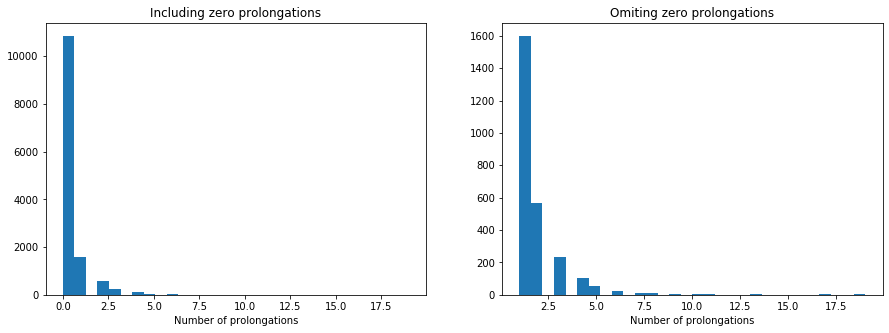

In [18]:
plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df_loans['lodging_cnt'], bins = 30)
plt.xlabel('Number of prolongations')
plt.title('Including zero prolongations')
plt.subplot(1,2,2)
plt.hist(df_loans[df_loans['lodging_cnt'] > 0]['lodging_cnt'], bins = 30)
plt.xlabel('Number of prolongations')
plt.title('Omiting zero prolongations')
plt.show()

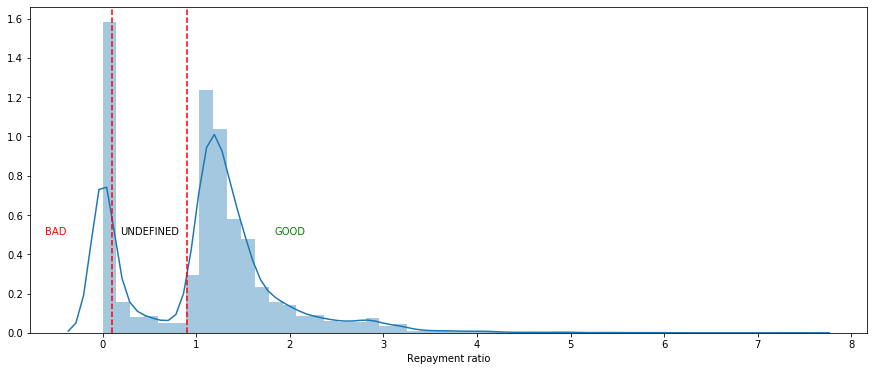

In [35]:
plt.figure(figsize=(15,6))
sns.distplot(df_loans['repayment_ratio'])
plt.axvline(x=0.1, linestyle='--', color='r')
plt.axvline(x=0.9, linestyle='--', color='r')
plt.text(x=-0.5, y=0.5, s='BAD', color='r', horizontalalignment='center')
plt.text(x=0.5, y=0.5, s='UNDEFINED', color='k', horizontalalignment='center')
plt.text(x=2, y=0.5, s='GOOD', color='g', horizontalalignment='center')
plt.xlabel('Repayment ratio')
plt.show()

<u>Thoughts</u>

Looks like it's better to investigate further who are those clients with repayments ratio from 10% to 60%.

In [8]:
(df_loans.groupby('profile_id')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profile_id', aggfunc='count'))
         .head()
)

,profiles
loans,
1,5894
2,1704
3,607
4,257
5,144


<u>Thoughts</u>
    
- most of the clients takes only one loan
- some clients recieves 2-5 loans
- only a few clients gets 6 and more loans

It looks natural to devide clients into 3 groups:
    
- `1st` loan
- `2nd` loan
- `3rd+` loan

In [9]:
(df_loans.groupby('profile_id')
         .agg(loans=pd.NamedAgg(column='loan', aggfunc='count'))
         .reset_index()
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profile_id', aggfunc='count'))
         .reset_index()
         .transform(func={'loans': (lambda x: '3+' if x >= 3 else str(x)), 'profiles': (lambda x: x)})
         .groupby('loans')
         .agg(profiles=pd.NamedAgg(column='profiles', aggfunc='sum'))
)

,profiles
loans,
1,5894
2,1704
3+,1145


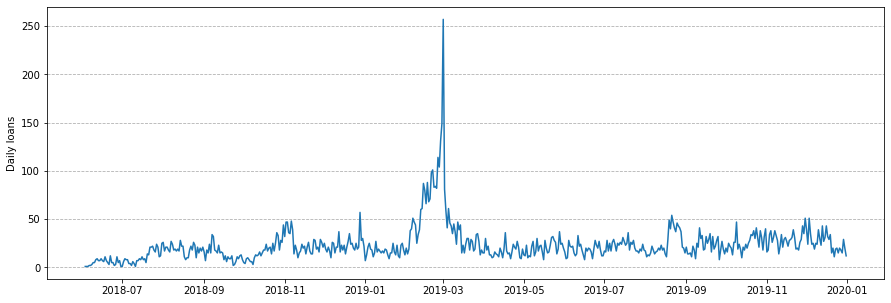

In [72]:
df_by_day = (df_loans['begin_date']
       .value_counts()
       .sort_index()
   
)

plt.figure(figsize=(15,5))
plt.plot(df_by_day.index, df_by_day, zorder=2)
plt.ylabel('Daily loans')
plt.grid(axis='y', linestyle='--')
plt.show()

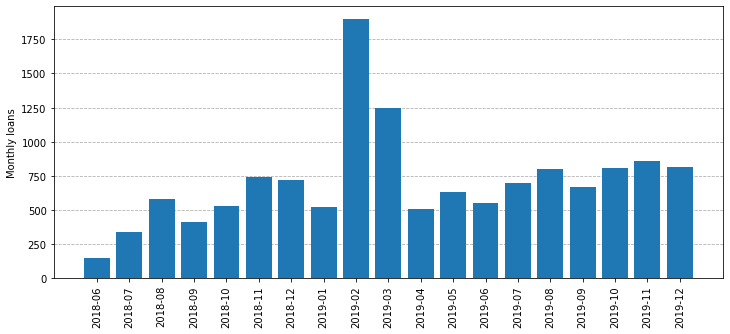

In [74]:
df_by_month = (df_loans['begin_date']
    .dt.strftime('%Y-%m')
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(12,5))
plt.bar(df_by_month.index, df_by_month, zorder=2)
plt.xticks(rotation='vertical')
plt.ylabel('Monthly loans')
plt.grid(axis='y', linestyle='--')
plt.show()

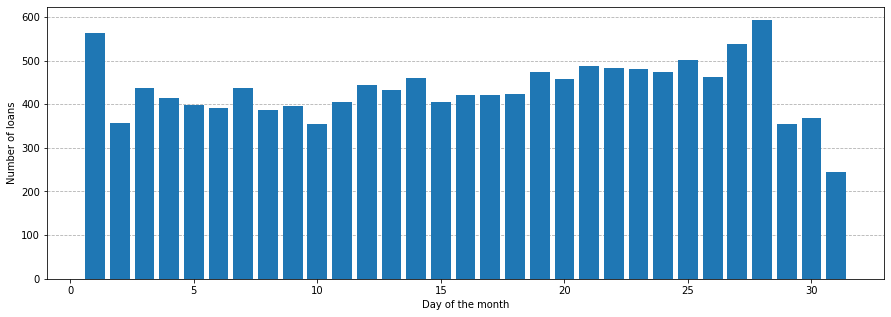

In [85]:
df_by_mday = (df_loans['begin_date']
    .dt.day
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(15,5))
plt.bar(df_by_mday.index, df_by_mday, zorder=2)
plt.xlabel('Day of the month')
plt.ylabel('Number of loans')
plt.grid(axis='y', linestyle='--')
plt.show()

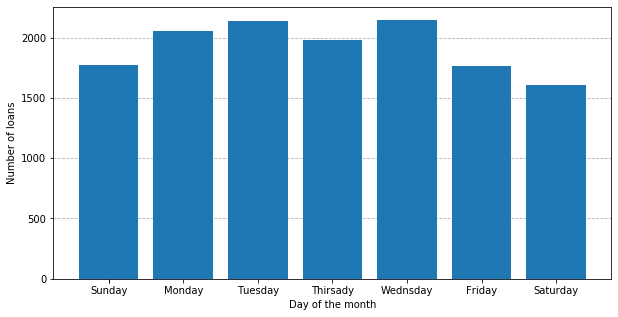

In [96]:
df_by_wday = (df_loans['begin_date']
    .dt.weekday
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,5))
plt.bar(df_by_wday.index, df_by_wday, zorder=2)
plt.xticks(ticks=[0,1,2,3,4,5,6,0], labels=['Sunday','Monday','Tuesday','Thirsady','Wednsday','Friday','Saturday'])
plt.xlabel('Day of the month')
plt.ylabel('Number of loans')
plt.grid(axis='y', linestyle='--')
plt.show()